In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import ast
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments
import numpy as np
from sklearn.metrics import f1_score
from transformers import AutoTokenizer
from datasets import Dataset
from peft import LoraConfig, get_peft_model, TaskType
import torch.nn as nn
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
import torch

pd.options.display.max_colwidth = 100

In [2]:
df = pd.read_parquet('./data/train.parquet')

# Exploration data analysis

In [3]:
df.dtypes

id               object
content          object
lang             object
manipulative       bool
techniques       object
trigger_words    object
dtype: object

In [4]:
# Display basic dataset information
print("Dataset Shape:", df.shape)
print("Dataset Columns:", df.columns.tolist())
df.head()

Dataset Shape: (3822, 6)
Dataset Columns: ['id', 'content', 'lang', 'manipulative', 'techniques', 'trigger_words']


,id,content,lang,manipulative,techniques,trigger_words
0,0bb0c7fa-101b-4583-a5f9-9d503339141c,"Новий огляд мапи DeepState від російського військового експерта, кухара путіна 2 розряду, спеціа...",uk,True,"[euphoria, loaded_language]","[[27, 63], [65, 88], [90, 183], [186, 308]]"
1,7159f802-6f99-4e9d-97bd-6f565a4a0fae,"Недавно 95 квартал жёстко поглумился над русскими баранами, которые притворяются украинцами. Про...",ru,True,"[loaded_language, cherry_picking]","[[0, 40], [123, 137], [180, 251], [253, 274]]"
2,e6a427f1-211f-405f-bd8b-70798458d656,🤩\nТим часом йде евакуація Бєлгородського автовокзалу - він оточений з невідомих простій русні п...,uk,True,"[loaded_language, euphoria]","[[55, 100]]"
3,1647a352-4cd3-40f6-bfa1-d87d42e34eea,В Україні найближчим часом мають намір посилити відповідальність за ухилення від мобілізації та ...,uk,False,None,None
4,9c01de00-841f-4b50-9407-104e9ffb03bf,"Расчёты 122-мм САУ 2С1 ""Гвоздика"" 132-й бригады 1-го АК 8-й армии ЮВО ВС России точным огнем, ко...",ru,True,[loaded_language],"[[114, 144]]"


In [5]:
def extract_unique_techniques(df):
    # Check if 'techniques' column exists
    if 'techniques' not in df.columns:
        raise ValueError("DataFrame must contain a 'techniques' column")

    # Initialize an empty set to store unique techniques
    unique_techniques = set()

    # Iterate through each row
    for techniques_array in df['techniques']:
        # Skip None or NaN values
        if techniques_array is None or (isinstance(techniques_array, float) and np.isnan(techniques_array)):
            continue

        # Add each technique to the set
        for technique in techniques_array:
            unique_techniques.add(technique)

    # Convert set to sorted list
    return sorted(list(unique_techniques))

In [6]:
technique_list = extract_unique_techniques(df)
technique_list

['appeal_to_fear',
 'bandwagon',
 'cherry_picking',
 'cliche',
 'euphoria',
 'fud',
 'glittering_generalities',
 'loaded_language',
 'straw_man',
 'whataboutism']

In [7]:
df_exploded = df.explode('techniques')
df_exploded['techniques'].value_counts()

techniques
loaded_language            1973
cherry_picking              512
glittering_generalities     483
cliche                      463
euphoria                    462
fud                         385
appeal_to_fear              300
whataboutism                158
bandwagon                   157
straw_man                   138
Name: count, dtype: int64

In [8]:
# Display detailed information about the dataset
df.info()

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3822 entries, 0 to 3821
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             3822 non-null   object
 1   content        3822 non-null   object
 2   lang           3822 non-null   object
 3   manipulative   3822 non-null   bool  
 4   techniques     2589 non-null   object
 5   trigger_words  2589 non-null   object
dtypes: bool(1), object(5)
memory usage: 153.2+ KB

Missing Values:
id                  0
content             0
lang                0
manipulative        0
techniques       1233
trigger_words    1233
dtype: int64


<Figure size 600x400 with 0 Axes>

<Axes: xlabel='lang'>

Text(0.5, 1.0, 'Distribution of Languages')

Text(0.5, 0, 'Language')

Text(0, 0.5, 'Count')

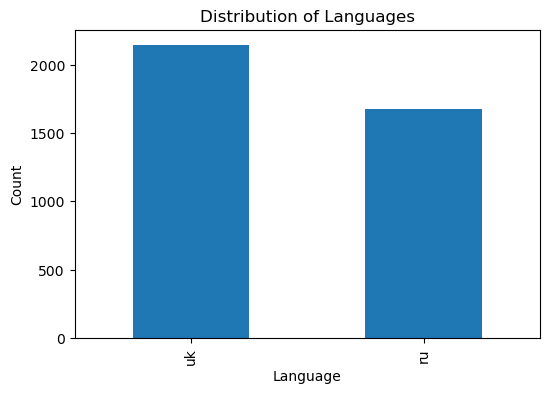

<Figure size 600x400 with 0 Axes>

<Axes: xlabel='manipulative'>

Text(0.5, 1.0, 'Distribution of Manipulative Flag')

Text(0.5, 0, 'Manipulative')

Text(0, 0.5, 'Count')

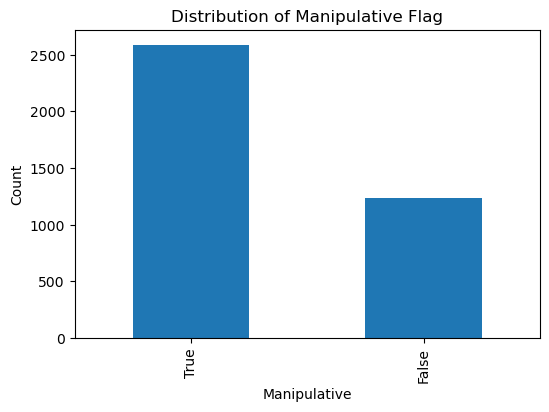

In [9]:
# Plot the distribution of languages in the dataset
plt.figure(figsize=(6,4))
df['lang'].value_counts().plot(kind='bar')
plt.title('Distribution of Languages')
plt.xlabel('Language')
plt.ylabel('Count')
plt.show()

# Plot the distribution of the manipulative flag
plt.figure(figsize=(6,4))
df['manipulative'].value_counts().plot(kind='bar')
plt.title('Distribution of Manipulative Flag')
plt.xlabel('Manipulative')
plt.ylabel('Count')
plt.show()


## Try to understand more about text

### Text cleaning

In [10]:
# Define a function for basic text cleaning
def clean_text(text):
    # Remove newline characters and extra spaces
    text = (
        text
        .replace('\n', ' ')
        .replace("&nbsp;", " ")
        .replace(u'\u00A0', " ")
        .replace("  ", " ")
        .strip()
    )
    # You can add additional cleaning steps (e.g., removing URLs, punctuation) as needed
    return text

# Apply cleaning to the 'content' column and create a new column 'clean_content'
df['clean_content'] = df['content'].apply(clean_text)

# Show an example of cleaned content
print("Example of Cleaned Content (Row 0):")
df[['content','clean_content']]

Example of Cleaned Content (Row 0):


,content,clean_content
0,"Новий огляд мапи DeepState від російського військового експерта, кухара путіна 2 розряду, спеціа...","Новий огляд мапи DeepState від російського військового експерта, кухара путіна 2 розряду, спеціа..."
1,"Недавно 95 квартал жёстко поглумился над русскими баранами, которые притворяются украинцами. Про...","Недавно 95 квартал жёстко поглумился над русскими баранами, которые притворяются украинцами. Про..."
2,🤩\nТим часом йде евакуація Бєлгородського автовокзалу - він оточений з невідомих простій русні п...,🤩 Тим часом йде евакуація Бєлгородського автовокзалу - він оточений з невідомих простій русні пр...
3,В Україні найближчим часом мають намір посилити відповідальність за ухилення від мобілізації та ...,В Україні найближчим часом мають намір посилити відповідальність за ухилення від мобілізації та ...
4,"Расчёты 122-мм САУ 2С1 ""Гвоздика"" 132-й бригады 1-го АК 8-й армии ЮВО ВС России точным огнем, ко...","Расчёты 122-мм САУ 2С1 ""Гвоздика"" 132-й бригады 1-го АК 8-й армии ЮВО ВС России точным огнем, ко..."
...,...,...
3817,"🤭\nросія ставить ППО на дахах адмінбудівель\nросійське керівництво перелякане, що військова пром...","🤭 росія ставить ППО на дахах адмінбудівель російське керівництво перелякане, що військова промис..."
3818,"К слову, Бабий не просто «ларечник», а и человек народного депутата СН Дубнова, а Дубнов - родст...","К слову, Бабий не просто «ларечник», а и человек народного депутата СН Дубнова, а Дубнов - родст..."
3819,"Глава ФСБ Бортников ответил журналистам, почему те, кто совершает преступления против России и р...","Глава ФСБ Бортников ответил журналистам, почему те, кто совершает преступления против России и р..."
3820,В ДНР завозили наркотики в бытовой технике\nОб этом сообщили в пресс-службе МВД по ДНР.\nУ предп...,В ДНР завозили наркотики в бытовой технике Об этом сообщили в пресс-службе МВД по ДНР. У предпри...


### Text **length** distribution

In [11]:
df['content'].str.len().describe()

count    3822.000000
mean      607.712716
std       606.421275
min       101.000000
25%       229.250000
50%       415.000000
75%       762.000000
max      4124.000000
Name: content, dtype: float64

<Axes: >

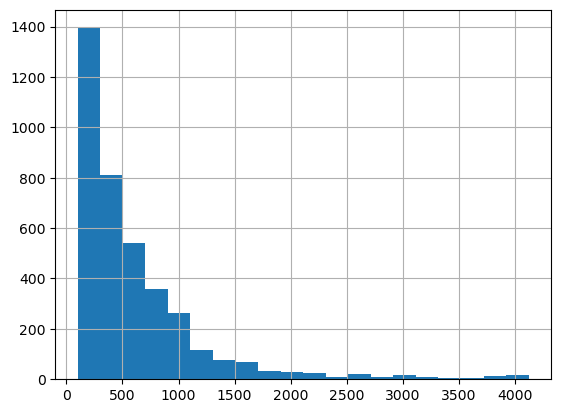

In [12]:
df['content'].str.len().hist(bins=20)

### Words count

In [13]:
df['words_count'] = df['content'].apply(lambda x: len(x.split()) if isinstance(x, str) else 0)
print("\nDataFrame with words count:")
df[['content', 'words_count']].head()


DataFrame with words count:


,content,words_count
0,"Новий огляд мапи DeepState від російського військового експерта, кухара путіна 2 розряду, спеціа...",49
1,"Недавно 95 квартал жёстко поглумился над русскими баранами, которые притворяются украинцами. Про...",160
2,🤩\nТим часом йде евакуація Бєлгородського автовокзалу - він оточений з невідомих простій русні п...,36
3,В Україні найближчим часом мають намір посилити відповідальність за ухилення від мобілізації та ...,124
4,"Расчёты 122-мм САУ 2С1 ""Гвоздика"" 132-й бригады 1-го АК 8-й армии ЮВО ВС России точным огнем, ко...",24


In [14]:
df['words_count'].describe()

count    3822.000000
mean       86.093145
std        85.902422
min         9.000000
25%        33.000000
50%        60.000000
75%       106.000000
max       707.000000
Name: words_count, dtype: float64

## Trigger words extraction

In [15]:
def extract_trigger_words(row):
    text = row['content']
    tw = row['trigger_words']
    # Check if trigger_words is not a numpy array or list (e.g. it's NaN)
    if not isinstance(tw, (np.ndarray, list)):
        return None
    # If the array/list is empty, return None.
    if len(tw) == 0:
        return None
    extracted_words = []
    # Iterate over each subarray representing [start, end] indexes.
    for indices in tw:
        # Ensure that indices is array-like with exactly two elements.
        if not isinstance(indices, (np.ndarray, list)) or len(indices) != 2:
            continue
        start, end = indices[0], indices[1]
        extracted_words.append(text[start:end])
    return extracted_words

# Apply the extraction function row-wise to create a new column with the trigger words.
df['trigger_words_text'] = df.apply(extract_trigger_words, axis=1)

print("DataFrame with Trigger Words Extracted:")
df[['clean_content', 'trigger_words', 'trigger_words_text']]

DataFrame with Trigger Words Extracted:


,clean_content,trigger_words,trigger_words_text
0,"Новий огляд мапи DeepState від російського військового експерта, кухара путіна 2 розряду, спеціа...","[[27, 63], [65, 88], [90, 183], [186, 308]]","[від російського військового експерта, кухара путіна 2 розряду, спеціаліста по снарядному голоду..."
1,"Недавно 95 квартал жёстко поглумился над русскими баранами, которые притворяются украинцами. Про...","[[0, 40], [123, 137], [180, 251], [253, 274]]","[Недавно 95 квартал жёстко поглумился над, дегенеративные, Как обычно стать на колени и лизать у..."
2,🤩 Тим часом йде евакуація Бєлгородського автовокзалу - він оточений з невідомих простій русні пр...,"[[55, 100]]",[він оточений з невідомих простій русні причин]
3,В Україні найближчим часом мають намір посилити відповідальність за ухилення від мобілізації та ...,None,None
4,"Расчёты 122-мм САУ 2С1 ""Гвоздика"" 132-й бригады 1-го АК 8-й армии ЮВО ВС России точным огнем, ко...","[[114, 144]]",[уничтожают украинских нацистов]
...,...,...,...
3817,"🤭 росія ставить ППО на дахах адмінбудівель російське керівництво перелякане, що військова промис...","[[2, 7], [43, 75], [77, 143], [145, 178], [340, 385], [492, 526], [540, 571]]","[росія, російське керівництво перелякане, що військова промисловість нашої держави може виготови..."
3818,"К слову, Бабий не просто «ларечник», а и человек народного депутата СН Дубнова, а Дубнов - родст...","[[25, 35], [103, 128], [149, 166]]","[«ларечник», проворовавшегося министра, Такой вот подряд.]"
3819,"Глава ФСБ Бортников ответил журналистам, почему те, кто совершает преступления против России и р...",None,None
3820,В ДНР завозили наркотики в бытовой технике Об этом сообщили в пресс-службе МВД по ДНР. У предпри...,None,None


<Figure size 1000x600 with 0 Axes>

(array([ 3.,  7.,  3.,  9., 17., 24., 30., 60., 53., 58., 77., 46., 43.,
        57., 46., 40., 43., 46., 51., 37., 36., 48., 48., 42., 53., 43.,
        50., 44., 36., 41., 32., 49., 49., 45., 41., 33., 38., 39., 38.,
        34., 32., 40., 33., 21., 27., 36., 26., 26., 24., 28., 22., 45.,
        25., 24., 28., 23., 29., 26., 28., 20., 27., 20., 19., 20., 19.,
        17., 25., 18., 17., 16., 29., 18., 19., 25., 18., 20., 21., 19.,
        28., 19., 22., 17., 21., 20., 16., 17., 21., 13., 15., 18., 24.,
        15., 18.,  9., 11., 17., 19.,  8., 10., 16., 12., 12., 14., 11.,
        11., 12.,  8., 13., 16., 14.,  6.,  9.,  9., 10.,  8.,  9., 14.,
        15., 10., 10., 10., 15.,  9.,  7., 10., 11., 10.,  7.,  8.,  9.,
         7., 15.,  9., 11., 15.,  6., 11.,  4.,  8.,  6., 10., 10.,  4.,
        12.,  9.,  2.,  4.,  5.,  5.,  3.,  6.,  8.,  6.,  7.,  5.,  9.,
         7.,  3.,  4.,  4.,  0.,  4., 11.,  8.,  3.,  2.,  6.,  2.,  1.,
         3.,  2.,  7.,  4.,  1.,  3.,  8.,  4.,  3.

Text(0.5, 1.0, 'Distribution of words count')

Text(0.5, 0, 'Word Count')

Text(0, 0.5, 'Frequency')

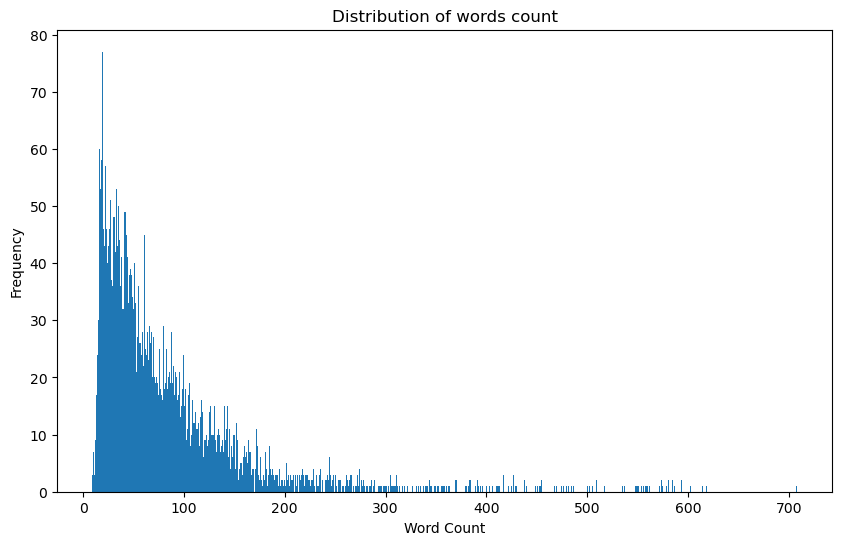

In [16]:
plt.figure(figsize=(10, 6))
plt.hist(df['words_count'], bins=range(min(df['words_count']), max(df['words_count']) + 2))
plt.title("Distribution of words count")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.show()

### Calculate word frequency

In [17]:
import re
from collections import Counter

# Concatenate all text entries into a single string
all_text = " ".join(df['content'].dropna())

# Convert to lowercase and remove punctuation (basic cleaning)
all_text = all_text.lower()
all_text = re.sub(r'[^\w\s]', '', all_text)

# Split the text into words and count frequency
words = all_text.split()
word_counts = Counter(words)

# Convert the word counts to a DataFrame for easier visualization
word_counts_df = pd.DataFrame(word_counts.items(), columns=['word', 'count']).sort_values(by='count', ascending=False)

print("\nTop words by frequency:")
word_counts_df.head(10)


Top words by frequency:


,word,count
137,в,7547
72,на,6272
63,и,3832
116,не,3520
16,та,3278
96,у,2996
42,з,2560
32,і,2472
107,за,2068
228,до,1899


In [18]:
word_counts_df.sort_values(by='count', ascending=True).head(10)

,word,count
47680,набираем,1
53607,зенітноракетним,1
64508,новация,1
53608,комплексам,1
65424,десантом,1
64510,разработают,1
53610,співпрацюватимуть,1
64511,аудио,1
53611,туристично,1
65423,экипажем,1


## Use tokenizer to analyze token count

Token indices sequence length is longer than the specified maximum sequence length for this model (662 > 512). Running this sequence through the model will result in indexing errors


<Figure size 1000x600 with 0 Axes>

(array([2., 2., 2., ..., 0., 0., 1.]),
 array([  18.,   19.,   20., ..., 1475., 1476., 1477.]),
 <BarContainer object of 1459 artists>)

Text(0.5, 1.0, 'HF Token Count Distribution')

Text(0.5, 0, 'Token Count')

Text(0, 0.5, 'Frequency')

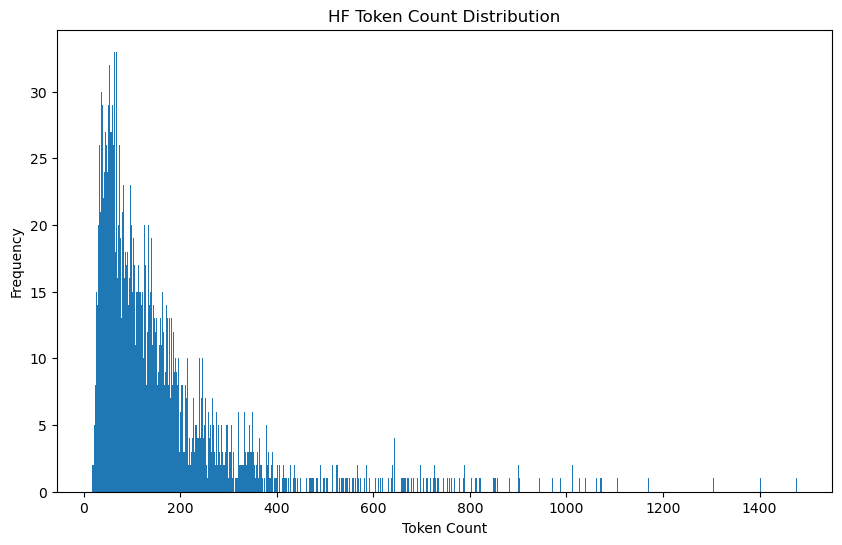

In [19]:
#tokenizer = AutoTokenizer.from_pretrained("KoichiYasuoka/roberta-base-ukrainian-upos")
#tokenizer = AutoTokenizer.from_pretrained("ukr-models/uk-ner")
#tokenizer = AutoTokenizer.from_pretrained("tartuNLP/Llama-2-7b-Ukrainian")
#tokenizer = AutoTokenizer.from_pretrained("ukr-models/uk-summarizer")
tokenizer = AutoTokenizer.from_pretrained("youscan/ukr-roberta-base")
df['hf_token_count'] = df['clean_content'].apply(lambda x: len(tokenizer.tokenize(x)))

plt.figure(figsize=(10, 6))
plt.hist(df['hf_token_count'], bins=range(min(df['hf_token_count']), max(df['hf_token_count'])+2))
plt.title("HF Token Count Distribution")
plt.xlabel("Token Count")
plt.ylabel("Frequency")
plt.show()

In [20]:
# Define tokenizers to compare.
# Uncomment or add additional tokenizers as needed.
tokenizer_dict = {
    "roberta_base_ukrainian_upos": AutoTokenizer.from_pretrained("KoichiYasuoka/roberta-base-ukrainian-upos"),
    "uk_ner": AutoTokenizer.from_pretrained("ukr-models/uk-ner"),
    #"llama2_ukrainian": AutoTokenizer.from_pretrained("tartuNLP/Llama-2-7b-Ukrainian", fast=True),
    "uk_summarizer": AutoTokenizer.from_pretrained("ukr-models/uk-summarizer"),
    "youscan_ukr_roberta": AutoTokenizer.from_pretrained("youscan/ukr-roberta-base")
}

# (Optional) Print each tokenizer's unknown token id.
for name, tok in tokenizer_dict.items():
    print(f"{name} unk_token_id: {tok.unk_token_id}")

df_test = df.copy(deep=True)

def compare_tokenizers(text, lang):
    results = {}
    for name, tok in tokenizer_dict.items():
        # Encode text (with special tokens) and convert back to tokens.
        token_ids = tok.encode(text, add_special_tokens=True)
        tokens = tok.convert_ids_to_tokens(token_ids)
        unk_id = tok.unk_token_id
        unk_count = token_ids.count(unk_id)
        total_tokens = len(token_ids)
        unk_ratio = unk_count / total_tokens if total_tokens > 0 else 0

        # Save results with a key prefix based on tokenizer name.
        results[f"{name}_tokens"] = tokens
        results[f"{name}_total_tokens"] = total_tokens
        results[f"{name}_unk_count"] = unk_count
        results[f"{name}_unk_ratio"] = unk_ratio
    return pd.Series(results)

# Apply the comparison function to each row.
df_stats = df_test.apply(lambda row: compare_tokenizers(row['clean_content'], row['lang']), axis=1)
df_test = pd.concat([df_test, df_stats], axis=1)

# Calculate average unknown ratio for each tokenizer across the dataset.
averages = {}
for name in tokenizer_dict.keys():
    avg_ratio = df_test[f"{name}_unk_ratio"].mean()
    averages[name] = avg_ratio

print("\nAverage Unknown Token Ratio per Tokenizer:")
for name, avg in averages.items():
    print(f"{name}: {avg}")

# Display selected columns with tokenization results.
columns_to_display = ['content', 'lang']
for name in tokenizer_dict.keys():
    columns_to_display.extend([
        f"{name}_tokens",
        f"{name}_total_tokens",
        f"{name}_unk_count",
        f"{name}_unk_ratio"
    ])

print("\nTokenization Unknown Analysis:")
df_test[columns_to_display]

Token indices sequence length is longer than the specified maximum sequence length for this model (728 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (664 > 512). Running this sequence through the model will result in indexing errors


roberta_base_ukrainian_upos unk_token_id: 3
uk_ner unk_token_id: 3
uk_summarizer unk_token_id: 2
youscan_ukr_roberta unk_token_id: 3

Average Unknown Token Ratio per Tokenizer:
roberta_base_ukrainian_upos: 0.017092124931256975
uk_ner: 0.01360112044417496
uk_summarizer: 0.012156437846490585
youscan_ukr_roberta: 0.0

Tokenization Unknown Analysis:


,content,lang,roberta_base_ukrainian_upos_tokens,roberta_base_ukrainian_upos_total_tokens,roberta_base_ukrainian_upos_unk_count,roberta_base_ukrainian_upos_unk_ratio,uk_ner_tokens,uk_ner_total_tokens,uk_ner_unk_count,uk_ner_unk_ratio,uk_summarizer_tokens,uk_summarizer_total_tokens,uk_summarizer_unk_count,uk_summarizer_unk_ratio,youscan_ukr_roberta_tokens,youscan_ukr_roberta_total_tokens,youscan_ukr_roberta_unk_count,youscan_ukr_roberta_unk_ratio
0,"Новий огляд мапи DeepState від російського військового експерта, кухара путіна 2 розряду, спеціа...",uk,"[[CLS], новий, огляд, мап, ##и, de, ##ep, ##st, ##ate, від, російського, військового, експерт, #...",93,0,0.000000,"[<s>, ▁Новий, ▁огляд, ▁ма, пи, ▁Deep, Stat, e, ▁від, ▁російського, ▁військово, го, ▁експерт, а, ...",107,0,0.000000,"[▁Нови, й, ▁, огляд, ▁ма, пи, ▁Deep, S, ta, te, ▁від, ▁, російськ, ого, ▁військов, ого, ▁експерт...",120,1,0.008333,"[<s>, ÐĿÐ¾Ð²Ð¸Ð¹, ĠÐ¾Ð³Ð»ÑıÐ´, ĠÐ¼Ð°, Ð¿Ð¸, ĠDe, ep, St, ate, ĠÐ²ÑĸÐ´, ĠÑĢÐ¾ÑģÑĸÐ¹ÑģÑĮÐºÐ¾Ð³Ð¾, ...",83,0,0.0
1,"Недавно 95 квартал жёстко поглумился над русскими баранами, которые притворяются украинцами. Про...",ru,"[[CLS], недав, ##но, 95, квартал, ж, ##ё, ##ст, ##ко, пог, ##лум, ##ил, ##ся, над, рус, ##ски, #...",421,2,0.004751,"[<s>, ▁Недавно, ▁95, ▁квартал, ▁ж, ё, ст, ко, ▁по, глу, ми, лся, ▁над, ▁рус, скими, ▁бара, на, м...",368,0,0.000000,"[▁Не, давно, ▁95, ▁квартал, ▁ж, ё, ст, ко, ▁погл, ум, ил, ся, ▁над, ▁русск, ими, ▁бара, нами, ,,...",397,0,0.000000,"[<s>, ÐĿÐµÐ´, Ð°Ð², Ð½Ð¾, Ġ95, ĠÐºÐ²Ð°ÑĢÑĤÐ°Ð», ĠÐ¶, Ñĳ, ÑģÑĤ, ÐºÐ¾, ĠÐ¿Ð¾Ð³, Ð»Ñĥ, Ð¼Ð¸, Ð»ÑģÑı...",380,0,0.0
2,🤩\nТим часом йде евакуація Бєлгородського автовокзалу - він оточений з невідомих простій русні п...,uk,"[[CLS], [UNK], тим, часом, йде, еваку, ##ація, б, ##є, ##л, ##город, ##ського, авто, ##вок, ##за...",65,3,0.046154,"[<s>, ▁, <unk>, ▁Тим, ▁часом, ▁йде, ▁еваку, ація, ▁Б, є, л, город, ського, ▁авто, вок, за, лу, ▁...",77,3,0.038961,"[▁, <unk>, ▁Тим, ▁час, ом, ▁, йде, ▁, е, ваку, ація, ▁Б, є, л, город, ського, ▁авто, вокзал, у, ...",81,2,0.024691,"[<s>, ðŁ¤©, ĠÐ¢Ð¸Ð¼, ĠÑĩÐ°ÑģÐ¾Ð¼, ĠÐ¹Ð´Ðµ, ĠÐµÐ²Ð°ÐºÑĥ, Ð°ÑĨÑĸÑı, ĠÐĳÑĶ, Ð», Ð³Ð¾ÑĢÐ¾Ð´, ÑģÑĮÐºÐ...",63,0,0.0
3,В Україні найближчим часом мають намір посилити відповідальність за ухилення від мобілізації та ...,uk,"[[CLS], в, україн, ##і, найближ, ##чим, часом, мають, намір, посил, ##ити, відповідальність, за,...",174,4,0.022989,"[<s>, ▁В, ▁Україні, ▁найближч, им, ▁часом, ▁мають, ▁на, мір, ▁поси, лити, ▁, відповідальність, ▁...",177,0,0.000000,"[▁В, ▁Україн, і, ▁най, ближ, чим, ▁час, ом, ▁, м, ають, ▁на, мір, ▁посил, ити, ▁відповід, альніс...",236,3,0.012712,"[<s>, ÐĴ, ĠÐ£ÐºÑĢÐ°ÑĹÐ½Ñĸ, ĠÐ½Ð°Ð¹Ð±Ð»Ð¸Ð¶ÑĩÐ¸Ð¼, ĠÑĩÐ°ÑģÐ¾Ð¼, ĠÐ¼Ð°ÑİÑĤÑĮ, ĠÐ½Ð°Ð¼ÑĸÑĢ, ĠÐ¿Ð¾Ñģ...",156,0,0.0
4,"Расчёты 122-мм САУ 2С1 ""Гвоздика"" 132-й бригады 1-го АК 8-й армии ЮВО ВС России точным огнем, ко...",ru,"[[CLS], рас, ##ч, ##ё, ##т, ##ы, 122, -, мм, са, ##у, 2, ##с, ##1, "", г, ##воз, ##дик, ##а, "", 1...",76,0,0.000000,"[<s>, ▁Рас, ч, ё, ты, ▁122, -, мм, ▁С, АУ, ▁2, С, 1, ▁"", Г, воз, ди, ка, "", ▁132, -, й, ▁бригад,...",69,0,0.000000,"[▁Рас, ч, ё, ты, ▁122, -, мм, ▁С, АУ, ▁2, С, 1, ▁"", Г, возд, ика, "", ▁132, -, й, ▁, бригад, ы, ▁...",68,1,0.014706,"[<s>, ÐłÐ°Ñģ, Ñĩ, Ñĳ, ÑĤÑĭ, Ġ122, -, Ð¼Ð¼, ĠÐ¡ÐĲ, Ð£, Ġ2, Ð¡, 1, Ġ"", Ðĵ, Ð²Ð¾Ð·, Ð´Ð¸ÐºÐ°, "", Ġ1...",73,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3817,"🤭\nросія ставить ППО на дахах адмінбудівель\nросійське керівництво перелякане, що військова пром...",uk,"[[CLS], [UNK], росія, ставить, п, ##по, на, дах, ##ах, ад, ##мін, ##буд, ##ів, ##ель, російськ, ...",137,2,0.014599,"[<s>, ▁, <unk>, ▁рос, ія, ▁, ставить, ▁П, ПО, ▁на, ▁да, х, ах, ▁ад, мін, буд, ів, ель, ▁рос, ійс...",153,2,0.013072,"[▁, <unk>, ▁ро, сія, ▁, ставить, ▁П, ПО, ▁на, ▁да, хах, ▁ад, мін, будів, ель, ▁, російськ, е, ▁к...",194,1,0.005155,"[<s>, ðŁ¤, Ń, ĠÑĢÐ¾ÑģÑĸÑı, ĠÑģÑĤÐ°Ð²Ð¸ÑĤÑĮ, ĠÐŁ, ÐŁÐŀ, ĠÐ½Ð°, ĠÐ´Ð°Ñħ, Ð°Ñħ, ĠÐ°Ð´Ð¼ÑĸÐ½, Ð±ÑĥÐ´...",118,0,0.0
3818,"К слову, Бабий не просто «ларечник», а и человек 

In [21]:
df_test['youscan_ukr_roberta_total_tokens'].describe()

count    3822.000000
mean      167.440607
std       166.966575
min        20.000000
25%        66.000000
50%       117.500000
75%       199.000000
max      1478.000000
Name: youscan_ukr_roberta_total_tokens, dtype: float64

# Model development

In [22]:
# Define a function for basic text cleaning
def additional_clean_text(text):
    # Remove newline characters and extra spaces
    text = text.replace('\n', ' ').strip()
    # You can add additional cleaning steps (e.g., removing URLs, punctuation) as needed
    return text

# Apply cleaning to the 'content' column and create a new column 'clean_content'
df['clean_content'] = df['content'].apply(additional_clean_text)

# Show an example of cleaned content
print("Example of Cleaned Content (Row 0):")
print(df.loc[0, 'clean_content'])


Example of Cleaned Content (Row 0):
Новий огляд мапи DeepState від російського військового експерта, кухара путіна 2 розряду, спеціаліста по снарядному голоду та ректора музичної академії міноборони рф Євгєнія Пригожина.  Пригожин прогнозує, що невдовзі настане день звільнення Криму і день розпаду росії. Каже, що передумови цього вже створені.  *Відео взяли з каналу  ФД .  @informnapalm


In [23]:
# Load the tokenizer from the selected Ukrainian model
# Load the Ukrainian-specific tokenizer from Hugging Face
#tokenizer = AutoTokenizer.from_pretrained("KoichiYasuoka/roberta-base-ukrainian-upos")
#tokenizer = AutoTokenizer.from_pretrained("ukr-models/uk-ner")
#tokenizer = AutoTokenizer.from_pretrained("tartuNLP/Llama-2-7b-Ukrainian")
#tokenizer = AutoTokenizer.from_pretrained("ukr-models/uk-summarizer")
tokenizer = AutoTokenizer.from_pretrained("youscan/ukr-roberta-base")

# Test the tokenizer on the cleaned text from the first row
sample_text = df.loc[0, 'clean_content']
print("Sample text:")
print(sample_text)


Sample text:
Новий огляд мапи DeepState від російського військового експерта, кухара путіна 2 розряду, спеціаліста по снарядному голоду та ректора музичної академії міноборони рф Євгєнія Пригожина.  Пригожин прогнозує, що невдовзі настане день звільнення Криму і день розпаду росії. Каже, що передумови цього вже створені.  *Відео взяли з каналу  ФД .  @informnapalm


In [24]:
# Tokenize the sample text
tokens = tokenizer.tokenize(sample_text)
print("Tokenized output (list of tokens):")
print(tokens)

# Reconstruct a human-readable string from tokens
reconstructed = tokenizer.convert_tokens_to_string(tokens)
print("Reconstructed text from tokens:")
print(reconstructed)

Tokenized output (list of tokens):
['ÐĿÐ¾Ð²Ð¸Ð¹', 'ĠÐ¾Ð³Ð»ÑıÐ´', 'ĠÐ¼Ð°', 'Ð¿Ð¸', 'ĠDe', 'ep', 'St', 'ate', 'ĠÐ²ÑĸÐ´', 'ĠÑĢÐ¾ÑģÑĸÐ¹ÑģÑĮÐºÐ¾Ð³Ð¾', 'ĠÐ²ÑĸÐ¹ÑģÑĮÐºÐ¾Ð²Ð¾Ð³Ð¾', 'ĠÐµÐºÑģÐ¿ÐµÑĢÑĤÐ°', ',', 'ĠÐºÑĥÑħ', 'Ð°ÑĢÐ°', 'ĠÐ¿Ñĥ', 'ÑĤÑĸÐ½Ð°', 'Ġ2', 'ĠÑĢÐ¾Ð·ÑĢÑıÐ´Ñĥ', ',', 'ĠÑģÐ¿ÐµÑĨÑĸÐ°Ð»ÑĸÑģÑĤÐ°', 'ĠÐ¿Ð¾', 'ĠÑģÐ½Ð°ÑĢÑıÐ´', 'Ð½Ð¾Ð¼Ñĥ', 'ĠÐ³Ð¾Ð»Ð¾Ð´Ñĥ', 'ĠÑĤÐ°', 'ĠÑĢÐµÐºÑĤÐ¾ÑĢÐ°', 'ĠÐ¼ÑĥÐ·Ð¸ÑĩÐ½Ð¾ÑĹ', 'ĠÐ°ÐºÐ°Ð´ÐµÐ¼ÑĸÑĹ', 'ĠÐ¼ÑĸÐ½', 'Ð¾Ð±Ð¾ÑĢÐ¾Ð½Ð¸', 'ĠÑĢ', 'ÑĦ', 'ĠÐĦÐ²', 'Ð³', 'ÑĶ', 'Ð½ÑĸÑı', 'ĠÐŁÑĢÐ¸', 'Ð³', 'Ð¾Ð¶Ð¸', 'Ð½Ð°', '.', 'Ġ', 'ĠÐŁÑĢÐ¸', 'Ð³', 'Ð¾Ð¶Ð¸', 'Ð½', 'ĠÐ¿ÑĢÐ¾Ð³Ð½Ð¾Ð·ÑĥÑĶ', ',', 'ĠÑīÐ¾', 'ĠÐ½ÐµÐ²Ð´Ð¾Ð²Ð·Ñĸ', 'ĠÐ½Ð°ÑģÑĤÐ°Ð½Ðµ', 'ĠÐ´ÐµÐ½ÑĮ', 'ĠÐ·Ð²ÑĸÐ»ÑĮÐ½ÐµÐ½Ð½Ñı', 'ĠÐļÑĢÐ¸Ð¼Ñĥ', 'ĠÑĸ', 'ĠÐ´ÐµÐ½ÑĮ', 'ĠÑĢÐ¾Ð·Ð¿Ð°Ð´Ñĥ', 'ĠÑĢÐ¾', 'ÑģÑĸÑĹ', '.', 'ĠÐļÐ°Ð¶Ðµ', ',', 'ĠÑīÐ¾', 'ĠÐ¿ÐµÑĢÐµÐ´ÑĥÐ¼Ð¾Ð²Ð¸', 'ĠÑĨÑĮÐ¾Ð³Ð¾', 'ĠÐ²Ð¶Ðµ', 'ĠÑģÑĤÐ²Ð¾ÑĢÐµÐ½Ñĸ', '.', 'Ġ', 'Ġ*', 'ÐĴÑĸÐ´ÐµÐ¾', 'ĠÐ²Ð·ÑıÐ»Ð¸', 'ĠÐ·', 'ĠÐºÐ°Ð½Ð°Ð»Ñĥ', 'Ġ', 'ĠÐ¤', 'ÐĶ', 'Ġ.', 'Ġ', 'Ġ@', 'inform', 'nap', 'al', 'm']
Re

In [25]:
# Define a tokenization function using the Hugging Face tokenizer
def hf_tokenize(text):
    # Tokenize the cleaned text using the pretrained Ukrainian tokenizer
    tokens = tokenizer.tokenize(text)
    return tokens

# Apply the Hugging Face tokenization to the cleaned content
df['hf_tokens'] = df['clean_content'].apply(hf_tokenize)
df['hf_token_count'] = df['hf_tokens'].apply(len)

# Show token count statistics
print("Token Count Statistics (Hugging Face Tokenizer):")
print(df['hf_token_count'].describe())

# Display an example of tokenized content for the first row
print("\nHugging Face Tokens in Row 0:")
print(df.loc[0, 'hf_tokens'])


Token indices sequence length is longer than the specified maximum sequence length for this model (663 > 512). Running this sequence through the model will result in indexing errors


Token Count Statistics (Hugging Face Tokenizer):
count    3822.000000
mean      168.940869
std       169.623805
min        19.000000
25%        65.250000
50%       119.000000
75%       202.000000
max      1507.000000
Name: hf_token_count, dtype: float64

Hugging Face Tokens in Row 0:
['ÐĿÐ¾Ð²Ð¸Ð¹', 'ĠÐ¾Ð³Ð»ÑıÐ´', 'ĠÐ¼Ð°', 'Ð¿Ð¸', 'ĠDe', 'ep', 'St', 'ate', 'ĠÐ²ÑĸÐ´', 'ĠÑĢÐ¾ÑģÑĸÐ¹ÑģÑĮÐºÐ¾Ð³Ð¾', 'ĠÐ²ÑĸÐ¹ÑģÑĮÐºÐ¾Ð²Ð¾Ð³Ð¾', 'ĠÐµÐºÑģÐ¿ÐµÑĢÑĤÐ°', ',', 'ĠÐºÑĥÑħ', 'Ð°ÑĢÐ°', 'ĠÐ¿Ñĥ', 'ÑĤÑĸÐ½Ð°', 'Ġ2', 'ĠÑĢÐ¾Ð·ÑĢÑıÐ´Ñĥ', ',', 'ĠÑģÐ¿ÐµÑĨÑĸÐ°Ð»ÑĸÑģÑĤÐ°', 'ĠÐ¿Ð¾', 'ĠÑģÐ½Ð°ÑĢÑıÐ´', 'Ð½Ð¾Ð¼Ñĥ', 'ĠÐ³Ð¾Ð»Ð¾Ð´Ñĥ', 'ĠÑĤÐ°', 'ĠÑĢÐµÐºÑĤÐ¾ÑĢÐ°', 'ĠÐ¼ÑĥÐ·Ð¸ÑĩÐ½Ð¾ÑĹ', 'ĠÐ°ÐºÐ°Ð´ÐµÐ¼ÑĸÑĹ', 'ĠÐ¼ÑĸÐ½', 'Ð¾Ð±Ð¾ÑĢÐ¾Ð½Ð¸', 'ĠÑĢ', 'ÑĦ', 'ĠÐĦÐ²', 'Ð³', 'ÑĶ', 'Ð½ÑĸÑı', 'ĠÐŁÑĢÐ¸', 'Ð³', 'Ð¾Ð¶Ð¸', 'Ð½Ð°', '.', 'Ġ', 'ĠÐŁÑĢÐ¸', 'Ð³', 'Ð¾Ð¶Ð¸', 'Ð½', 'ĠÐ¿ÑĢÐ¾Ð³Ð½Ð¾Ð·ÑĥÑĶ', ',', 'ĠÑīÐ¾', 'ĠÐ½ÐµÐ²Ð´Ð¾Ð²Ð·Ñĸ', 'ĠÐ½Ð°ÑģÑĤÐ°Ð½Ðµ', 'ĠÐ´ÐµÐ½ÑĮ', 'ĠÐ·Ð²ÑĸÐ»ÑĮÐ½ÐµÐ½Ð½Ñı', 'ĠÐļÑĢÐ¸Ð¼Ñĥ', 'ĠÑĸ', 'ĠÐ´ÐµÐ½ÑĮ', 'ĠÑĢÐ¾Ð·Ð¿Ð°Ð´Ñĥ', 'ĠÑĢÐ¾'

In [26]:
# For reproducibility
# stratification sklearn?
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

print("Training samples:", len(train_df))
print("Validation samples:", len(val_df))


Training samples: 3057
Validation samples: 765


In [39]:
def parse_techniques(techniques):
    if techniques is None:
        return []
    if isinstance(techniques, str):
        if techniques.strip() == "":
            return []
        try:
            return ast.literal_eval(techniques)
        except Exception as e:
            print("Error parsing techniques:", techniques, e)
            return []
    # If techniques is already an iterable (e.g., list or numpy array), convert it to a list.
    try:
        return list(techniques)
    except TypeError:
        return techniques

df['techniques_parsed'] = df['techniques'].apply(parse_techniques)

# Dynamically compute the full set of techniques from the training set.
all_techniques = set()
for tech_list in df['techniques_parsed']:
    all_techniques.update(tech_list)
all_techniques = sorted(all_techniques)  # Sorted order for consistency

# Initialize the MultiLabelBinarizer with the full set of techniques.
mlb = MultiLabelBinarizer(classes=all_techniques)

# Fit and transform the training set; transform the validation set.
labels = mlb.fit_transform(df['techniques_parsed'])

# Add the binary label vectors as a new column ('labels') in the DataFrames.
df['labels_vector'] = list(labels)

# Inspect a sample.
print("Sample multilabel vector from training set:", df.iloc[0]['labels_vector'])
df[['techniques', 'labels_vector']]

Sample multilabel vector from training set: [0 0 0 0 1 0 0 1 0 0]


,techniques,labels_vector
0,"[euphoria, loaded_language]","[0, 0, 0, 0, 1, 0, 0, 1, 0, 0]"
1,"[loaded_language, cherry_picking]","[0, 0, 1, 0, 0, 0, 0, 1, 0, 0]"
2,"[loaded_language, euphoria]","[0, 0, 0, 0, 1, 0, 0, 1, 0, 0]"
3,None,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
4,[loaded_language],"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]"
...,...,...
3817,"[loaded_language, euphoria]","[0, 0, 0, 0, 1, 0, 0, 1, 0, 0]"
3818,[loaded_language],"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]"
3819,None,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
3820,None,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


In [42]:
# Initialize the stratified splitter; here we use a 80/20 split.
msss = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Get the train and test indices
for train_idx, test_idx in msss.split(df, labels):
    train_df = df.iloc[train_idx].reset_index(drop=True)
    val_df = df.iloc[test_idx].reset_index(drop=True)
# Now df_train and df_test preserve the multilabel distribution across splits.
print("Training set size:", len(train_df))
print("Test set size:", len(val_df))

Training set size: 3057
Test set size: 765


In [43]:
train_df

,id,content,lang,manipulative,techniques,trigger_words,clean_content,words_count,trigger_words_text,hf_token_count,hf_tokens,techniques_parsed,labels_vector
0,0bb0c7fa-101b-4583-a5f9-9d503339141c,"Новий огляд мапи DeepState від російського військового експерта, кухара путіна 2 розряду, спеціа...",uk,True,"[euphoria, loaded_language]","[[27, 63], [65, 88], [90, 183], [186, 308]]","Новий огляд мапи DeepState від російського військового експерта, кухара путіна 2 розряду, спеціа...",49,"[від російського військового експерта, кухара путіна 2 розряду, спеціаліста по снарядному голоду...",85,"[ÐĿÐ¾Ð²Ð¸Ð¹, ĠÐ¾Ð³Ð»ÑıÐ´, ĠÐ¼Ð°, Ð¿Ð¸, ĠDe, ep, St, ate, ĠÐ²ÑĸÐ´, ĠÑĢÐ¾ÑģÑĸÐ¹ÑģÑĮÐºÐ¾Ð³Ð¾, ĠÐ²Ñĸ...","[euphoria, loaded_language]","[0, 0, 0, 0, 1, 0, 0, 1, 0, 0]"
1,e6a427f1-211f-405f-bd8b-70798458d656,🤩\nТим часом йде евакуація Бєлгородського автовокзалу - він оточений з невідомих простій русні п...,uk,True,"[loaded_language, euphoria]","[[55, 100]]",🤩 Тим часом йде евакуація Бєлгородського автовокзалу - він оточений з невідомих простій русні пр...,36,[він оточений з невідомих простій русні причин],61,"[ðŁ¤©, ĠÐ¢Ð¸Ð¼, ĠÑĩÐ°ÑģÐ¾Ð¼, ĠÐ¹Ð´Ðµ, ĠÐµÐ²Ð°ÐºÑĥ, Ð°ÑĨÑĸÑı, ĠÐĳÑĶ, Ð», Ð³Ð¾ÑĢÐ¾Ð´, ÑģÑĮÐºÐ¾Ð³Ð¾...","[loaded_language, euphoria]","[0, 0, 0, 0, 1, 0, 0, 1, 0, 0]"
2,1647a352-4cd3-40f6-bfa1-d87d42e34eea,В Україні найближчим часом мають намір посилити відповідальність за ухилення від мобілізації та ...,uk,False,None,None,В Україні найближчим часом мають намір посилити відповідальність за ухилення від мобілізації та ...,124,None,154,"[ÐĴ, ĠÐ£ÐºÑĢÐ°ÑĹÐ½Ñĸ, ĠÐ½Ð°Ð¹Ð±Ð»Ð¸Ð¶ÑĩÐ¸Ð¼, ĠÑĩÐ°ÑģÐ¾Ð¼, ĠÐ¼Ð°ÑİÑĤÑĮ, ĠÐ½Ð°Ð¼ÑĸÑĢ, ĠÐ¿Ð¾ÑģÐ¸Ð»Ð...",[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
3,1417fffa-461c-4bf7-bea5-398e8ea5db81,"⚡️\nКитай надеется, что пакетное соглашение о транспортировке зерна по Чёрному морю будет и дале...",ru,False,None,None,"⚡️ Китай надеется, что пакетное соглашение о транспортировке зерна по Чёрному морю будет и далее...",21,None,45,"[âļ, ¡ï¸ı, ĠÐļÐ¸ÑĤÐ°Ð¹, ĠÐ½Ð°, Ð´Ðµ, ÐµÑĤÑģÑı, ,, ĠÑĩÑĤÐ¾, ĠÐ¿Ð°ÐºÐµÑĤ, Ð½Ð¾Ðµ, ĠÑģ, Ð¾Ð³, Ð»Ð°,...",[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
4,f8021666-1636-4e1f-b8e3-535860eca5ce,"До сьогоднішнього дня Джо Байден був у Києві понад 8 років тому. Та попри очевидні ризики, прези...",uk,True,"[loaded_language, glittering_generalities, euphoria]","[[65, 223], [225, 697]]","До сьогоднішнього дня Джо Байден був у Києві понад 8 років тому. Та попри очевидні ризики, прези...",108,"[Та попри очевидні ризики, президент США та лідер демократичного світу приїжджає у вільну країну...",146,"[ÐĶÐ¾, ĠÑģÑĮÐ¾Ð³Ð¾Ð´Ð½ÑĸÑĪÐ½ÑĮÐ¾Ð³Ð¾, ĠÐ´Ð½Ñı, ĠÐĶÐ¶Ð¾, ĠÐĳÐ°Ð¹, Ð´ÐµÐ½, ĠÐ±ÑĥÐ², ĠÑĥ, ĠÐļÐ¸ÑĶÐ²...","[loaded_language, glittering_generalities, euphoria]","[0, 0, 0, 0, 1, 0, 1, 1, 0, 0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3052,423230c2-625a-4de2-ba66-57ebdb1a798e,Наш символ гордості та сили.\nНашої стійкості та незламності. \nЦе наша ВОЛЯ об’єднана в один зн...,uk,True,"[glittering_generalities, cliche]","[[0, 97], [302, 358], [360, 405]]",Наш символ гордості та сили. Нашої стійкості та незламності. Це наша ВОЛЯ об’єднана в один знак...,64,[Наш символ гордості та сили.\nНашої стійкості та незламності. \nЦе наша ВОЛЯ об’єднана в один з...,108,"[ÐĿÐ°ÑĪ, ĠÑģÐ¸Ð¼Ð²Ð¾Ð», ĠÐ³Ð¾ÑĢÐ´Ð¾ÑģÑĤÑĸ, ĠÑĤÐ°, ĠÑģÐ¸Ð»Ð¸, ., ĠÐĿÐ°, ÑĪÐ¾ÑĹ, ĠÑģÑĤÑĸÐ¹ÐºÐ¾ÑģÑĤ...","[glittering_generalities, cliche]","[0, 0, 0, 1, 0, 0, 1, 0, 0, 0]"
3053,0e5dd135-ef41-48d3-b274-faedf3a2126c,"🤭\nросія ставить ППО на дахах адмінбудівель\nросійське керівництво перелякане, що військова пром...",uk,True,"[loaded_language, euphoria]","[[2, 7], [43, 75], [77, 143], [145, 178], [340, 385], [492, 526], [540, 571]]","🤭 росія ставить ППО на дахах адмінбудівель російське керівництво перелякане, що військова промис...",82,"[росія, російське керівництво перелякане, що військова промисловість нашої держави може виготови...",122,"[ðŁ¤, Ń, ĠÑĢÐ¾ÑģÑĸÑı, ĠÑģÑĤÐ°Ð²Ð¸ÑĤÑĮ, ĠÐŁ, ÐŁÐŀ, ĠÐ½Ð°, ĠÐ´Ð°Ñħ, Ð°Ñħ, ĠÐ°Ð´Ð¼ÑĸÐ½, Ð±ÑĥÐ´ÑĸÐ²Ð...","[loaded_language, euphoria]","[0, 0, 0, 0, 1, 0, 0

In [44]:
# Load the tokenizer (using the chosen Ukrainian model)
tokenizer = AutoTokenizer.from_pretrained("youscan/ukr-roberta-base")
tokenizer.truncation_side = "left"

# A preprocessing function for our texts
def preprocess_classification(example):
    # Tokenize the 'clean_content'; adjust max_length as needed.
    encoding = tokenizer(example['clean_content'], truncation=True, padding="max_length", max_length=256)
    # Add the binary label vector
    encoding['labels'] = [float(l) for l in example['labels_vector']]
    return encoding

# Convert our pandas DataFrames to Hugging Face Datasets
train_dataset = Dataset.from_pandas(train_df[['clean_content', 'labels_vector']])
val_dataset = Dataset.from_pandas(val_df[['clean_content', 'labels_vector']])

# Apply tokenization/preprocessing
train_dataset = train_dataset.map(preprocess_classification, batched=False)
val_dataset = val_dataset.map(preprocess_classification, batched=False)

train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
val_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

print("Example from training dataset:", train_dataset[0])

Map: 100%|██████████| 765/765 [00:00<00:00, 1089.98 examples/s]

Example from training dataset: {'input_ids': tensor([    0, 13612,  8817,   475,   533, 15663,  4974, 11407,  8598,   358,
         7968,  8738, 25486,    16,  6832,   629,  3234,  8919,   416, 26840,
           16, 15714,   367, 27823,   630, 15688,   342, 25944, 18985,  6407,
         4596, 16989,   615,   339,  2962,   308,   318,  4082,  1089,   308,
         2143,   326,    18,   225,  1089,   308,  2143,   264, 47933,    16,
          402, 19830, 37081,  1631,  6299,  5069,   320,  1631, 24347,   705,
         1342,    18, 39392,    16,   402, 26299,   948,   969, 11358,    18,
          225,  6370, 27020,  4913,   284, 10694,   225,   758,   548,  1473,
          225,  6499, 37503, 40961,  1245,    81,     2,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     

### First version

In [33]:
# Load the model with the appropriate classification head.
# Note: We set num_labels to our technique count.
id2label = {i: label for i, label in enumerate(technique_list)}
label2id = {label: i for i, label in enumerate(technique_list)}

model = AutoModelForSequenceClassification.from_pretrained(
    "youscan/ukr-roberta-base",
    num_labels=len(technique_list),
    problem_type="multi_label_classification",
    id2label=id2label,
    label2id=label2id,
)

# Define a custom compute_metrics function for Macro-F1
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    # Use sigmoid to get probabilities
    preds = torch.sigmoid(torch.tensor(logits)).numpy()
    # Binarize predictions (you may choose a threshold, e.g., 0.5)
    preds = (preds > 0.5).astype(int)
    # Compute macro F1 score
    f1 = f1_score(labels, preds, average='macro', zero_division=0)
    return {"macro_f1": f1}

# Set up training arguments
training_args = TrainingArguments(
    output_dir="./models/multilabel_model",
    eval_strategy="epoch",
    num_train_epochs=5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=2e-5,
    weight_decay=0.01,
    fp16=True
    #load_best_model_at_end=True
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

# Train the model
trainer.train()


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at youscan/ukr-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Macro F1
1,No log,0.273165,0.122914
2,0.297700,0.267329,0.152222
3,0.254700,0.279333,0.202722
4,0.216200,0.276570,0.228952
5,0.216200,0.275453,0.247152


TrainOutput(global_step=1915, training_loss=0.2423843702510505, metrics={'train_runtime': 341.6557, 'train_samples_per_second': 44.738, 'train_steps_per_second': 5.605, 'total_flos': 2010970675768320.0, 'train_loss': 0.2423843702510505, 'epoch': 5.0})

### Second version

In [43]:
# Load the model with the appropriate classification head.
# Note: We set num_labels to our technique count.
id2label = {i: label for i, label in enumerate(technique_list)}
label2id = {label: i for i, label in enumerate(technique_list)}

model = AutoModelForSequenceClassification.from_pretrained(
    "youscan/ukr-roberta-base",
    num_labels=len(technique_list),
    problem_type="multi_label_classification",
    id2label=id2label,
    label2id=label2id,
)
model


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at youscan/ukr-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(52000, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [44]:
# Set up LoRA configuration.
peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=8,
    lora_alpha=32,
    lora_dropout=0.01,
    target_modules=["query", "key", "value"]
)

# After wrapping with LoRA:
model = get_peft_model(model, peft_config)

# Unfreeze the classifier head:
for param in model.classifier.parameters():
    param.requires_grad = True

model.print_trainable_parameters()

trainable params: 1,638,932 || all params: 127,026,452 || trainable%: 1.2902


In [45]:
# Set up training arguments.
training_args = TrainingArguments(
    output_dir="./models/multilabel_model",
    eval_strategy="epoch",
    num_train_epochs=5,
    per_device_train_batch_size=12,
    per_device_eval_batch_size=12,
    learning_rate=2e-5,
    weight_decay=0.01,
    fp16=True,
    # load_best_model_at_end=True  # Uncomment if needed.
)

# Define a compute_metrics function as needed for your task.
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    # Convert logits to binary predictions using a threshold of 0.0
    preds = (predictions > 0).astype(int)
    f1_macro = f1_score(labels, preds, average="macro", zero_division=0)
    return {"f1_macro": f1_macro}

# Initialize the Trainer.
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

# Train the model.
trainer.train()

No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Epoch,Training Loss,Validation Loss,F1 Macro
1,No log,0.310220,0.062206
2,0.343600,0.300958,0.067095
3,0.343600,0.294412,0.078763
4,0.297400,0.289068,0.083679
5,0.297400,0.287714,0.090576


TrainOutput(global_step=1275, training_loss=0.3140905043658088, metrics={'train_runtime': 211.6004, 'train_samples_per_second': 72.235, 'train_steps_per_second': 6.026, 'total_flos': 2035402806712320.0, 'train_loss': 0.3140905043658088, 'epoch': 5.0})

In [24]:
trainer.save_model("./models/lora_model")

### Third version

In [45]:
label_counts = df_exploded['techniques'].value_counts().to_dict()
total_samples = len(df['techniques'])
total_samples, label_counts

(3822,
 {'loaded_language': 1973,
  'cherry_picking': 512,
  'glittering_generalities': 483,
  'cliche': 463,
  'euphoria': 462,
  'fud': 385,
  'appeal_to_fear': 300,
  'whataboutism': 158,
  'bandwagon': 157,
  'straw_man': 138})

In [46]:
pos_weight_list = []
for label in sorted(label_counts.keys()):
    count = label_counts[label]
    neg = total_samples - count
    pos_weight = neg / count
    pos_weight_list.append(pos_weight)

pos_weight = torch.tensor(pos_weight_list, dtype=torch.float)
print("Computed pos_weight:", pos_weight)

Computed pos_weight: tensor([11.7400, 23.3439,  6.4648,  7.2549,  7.2727,  8.9273,  6.9130,  0.9372,
        26.6957, 23.1899])


In [51]:
# Assume technique_list is the sorted list of labels (in the same order as above).
technique_list = sorted(label_counts.keys())
id2label = {i: label for i, label in enumerate(technique_list)}
label2id = {label: i for i, label in enumerate(technique_list)}

# Load the model (multilabel classification)
model = AutoModelForSequenceClassification.from_pretrained(
    "youscan/ukr-roberta-base",
    num_labels=len(technique_list),
    problem_type="multi_label_classification",
    id2label=id2label,
    label2id=label2id,
)

# Define a custom Trainer that uses a weighted loss.
class WeightedLossTrainer(Trainer):
    def __init__(self, pos_weight, **kwargs):
        super().__init__(**kwargs)
        # Cache the loss function once (move to device later in compute_loss if needed).
        self.cached_loss_fct = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        # Remove the extra keyword if present.
        inputs.pop("num_items_in_batch", None)
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        # Move the cached loss function's pos_weight to the correct device once per batch.
        loss_fct = nn.BCEWithLogitsLoss(pos_weight=self.cached_loss_fct.pos_weight.to(logits.device))
        loss = loss_fct(logits, labels.float())
        return (loss, outputs) if return_outputs else loss

# Define a compute_metrics function (using macro F1 as an example)
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    # Apply sigmoid to get probabilities and then threshold at 0.5
    preds = (torch.sigmoid(torch.tensor(logits)) > 0.5).int().numpy()
    f1_macro = f1_score(labels, preds, average="macro", zero_division=0)
    return {"macro_f1": f1_macro}

# Set up training arguments.
training_args = TrainingArguments(
    output_dir="./models/multilabel_model",
    eval_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=5,  # Increase epochs if needed
    per_device_train_batch_size=12,
    per_device_eval_batch_size=12,
    learning_rate=2e-5,
    weight_decay=0.01,
    fp16=True,
    #load_best_model_at_end=True,
)

# Assume train_dataset and val_dataset are already prepared Hugging Face datasets.
# They should include the fields "input_ids", "attention_mask", and "labels" (with labels as float vectors).

# Initialize the custom Trainer.
trainer = WeightedLossTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    pos_weight=pos_weight,
)

# Start training.
trainer.train()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at youscan/ukr-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Macro F1
1,No log,1.036264,0.344613
2,0.962000,0.940040,0.376286
3,0.962000,0.950767,0.380109
4,0.677100,1.077966,0.392178
5,0.677100,1.117688,0.396215


TrainOutput(global_step=1275, training_loss=0.7590558100681679, metrics={'train_runtime': 289.9037, 'train_samples_per_second': 52.724, 'train_steps_per_second': 4.398, 'total_flos': 2010970675768320.0, 'train_loss': 0.7590558100681679, 'epoch': 5.0})

#### Evaluation

In [53]:
predictions = trainer.predict(val_dataset)
# predictions.predictions is an array of logits.
# Convert logits to probabilities, then threshold to get binary predictions.
preds = (torch.sigmoid(torch.tensor(predictions.predictions)) > 0.5).int().numpy()

# Optionally, map binary predictions to label names.
results = []
for sample_pred in preds:
    sample_labels = [id2label[i] for i, flag in enumerate(sample_pred) if flag == 1]
    results.append(sample_labels)

print("Predicted labels for test data:")
print("Evaluation on test data:\n")
for i, sample in enumerate(val_dataset):
    # Get the original text from the test sample.
    token_ids = sample.get("input_ids", "[No text provided]")
    text = tokenizer.decode(token_ids)

    # Convert true labels (float vector) to label names.
    actual_label_names = [id2label[idx] for idx, val in enumerate(sample["labels"]) if val > 0.5]

    # Convert predicted binary vector to label names.
    predicted_label_names = [id2label[idx] for idx, val in enumerate(preds[i]) if val == 1]

    print(f"Sample {i+1}:")
    print("Text:", text)
    print("Actual Labels:", actual_label_names)
    print("Predicted Labels:", predicted_label_names)
    print("-" * 50)

Predicted labels for test data:
Evaluation on test data:

Sample 1:
Text: <s>ала 95": Надеюсь, у режиссеров хватит сил извиниться Так, глава города призвал режиссеров шоу извиниться перед людьми за шутки. "Очень прав был Петлюра, который говорил: "Нам не так страшны московские вши, нам страшны украинские гниды". Шутки о "сеськах" из Скадовска, наверное, кому-то кажутся очень остроумными. Но пусть это будет на совести режиссеров. Надеюсь, у них хватит силы извиниться перед украинцами Скадовск сегодня в оккупации, и действительно чего сейчас нуждаются скадовчане в поддержке. Знаю, что у нас много людей были русскоязычными, но все хорошо понимают украинский, и хорошо говорят по-украински", -  отметил мэр  . Яковлев также объявил флешмоб "Скадовск говорит по-украински". Он предложил всем жителям Скадовска зачитать что-нибудь на украинском.</s>
Actual Labels: ['cherry_picking', 'loaded_language']
Predicted Labels: ['appeal_to_fear', 'cherry_picking', 'cliche', 'fud', 'loaded_language', 'str

In [54]:
predictions = trainer.predict(val_dataset)
# predictions.predictions is an array of logits.
# Convert logits to probabilities, then threshold to get binary predictions.
preds = (torch.sigmoid(torch.tensor(predictions.predictions)) > 0.5).int().numpy()

# Create a list mapping predicted binary vectors to label names.
predicted_labels_list = []
for sample_pred in preds:
    sample_labels = [id2label[i] for i, flag in enumerate(sample_pred) if flag == 1]
    predicted_labels_list.append(sample_labels)

# Now, assume you still have your original validation DataFrame "val_df"
# with the original columns "id" and "clean_content".
# Make sure the order of rows in val_df matches the order in val_dataset.
val_ids = val_df["id"].tolist()
val_texts = val_df["clean_content"].tolist()

print("Evaluation on test data:\n")
# Iterate over each sample and print the id, clean text, actual labels, and predicted labels.
for i, sample in enumerate(val_dataset):
    sample_id = val_ids[i]
    sample_text = val_texts[i]

    # Get actual labels from the dataset sample (assuming labels are a binary vector)
    actual_label_names = [id2label[idx] for idx, val in enumerate(sample["labels"]) if val > 0.5]

    predicted_label_names = predicted_labels_list[i]

    print(f"Sample {i+1} (ID: {sample_id}):")
    print("Clean Text:", sample_text)
    print("Actual Labels:", actual_label_names)
    print("Predicted Labels:", predicted_label_names)
    print("-" * 50)

Evaluation on test data:

Sample 1 (ID: 7159f802-6f99-4e9d-97bd-6f565a4a0fae):
Clean Text: Недавно 95 квартал жёстко поглумился над русскими баранами, которые притворяются украинцами. Про Скадовск там шуточки были дегенеративные. И что предлагают сделать русские бараны? Как обычно стать на колени и лизать украинскую туфлю, чтобы их простили. Украинцы же как негры, перед ними нужно бесконечно извиняться.  ‼️  Мэр оккупированного Скадовска Яковлев прокомментировал номер "Квартала 95": Надеюсь, у режиссеров хватит сил извиниться Так, глава города призвал режиссеров шоу извиниться перед людьми за шутки. "Очень прав был Петлюра, который говорил: "Нам не так страшны московские вши, нам страшны украинские гниды". Шутки о "сеськах" из Скадовска, наверное, кому-то кажутся очень остроумными. Но пусть это будет на совести режиссеров. Надеюсь, у них хватит силы извиниться перед украинцами Скадовск сегодня в оккупации, и действительно чего сейчас нуждаются скадовчане в поддержке. Знаю, что у нас мн

#### F1 score

In [55]:
# Get predictions from your Trainer on your test dataset.
results = trainer.predict(val_dataset)
logits = results.predictions  # raw logits from the model
true_labels = results.label_ids  # true labels as a numpy array

# Convert logits to probabilities using sigmoid and then threshold to get binary predictions.
pred_probs = torch.sigmoid(torch.tensor(logits))
preds = (pred_probs > 0.5).int().numpy()

# Ensure the true labels are integer type.
true_labels = true_labels.astype(int)

# Compute F1 scores for each label individually.
f1_per_label = f1_score(true_labels, preds, average=None, zero_division=0)

# Print F1 scores per label.
print("F1 Score for each label:")
for idx, f1 in enumerate(f1_per_label):
    print(f"Label '{id2label[idx]}': {f1:.4f}")

# Optionally, compute and print overall Macro and Micro F1 scores.
macro_f1 = f1_score(true_labels, preds, average='macro', zero_division=0)
micro_f1 = f1_score(true_labels, preds, average='micro', zero_division=0)
print(f"\nOverall Macro F1: {macro_f1:.4f}")
print(f"Overall Micro F1: {micro_f1:.4f}")

F1 Score for each label:
Label 'appeal_to_fear': 0.2581
Label 'bandwagon': 0.2342
Label 'cherry_picking': 0.4689
Label 'cliche': 0.3274
Label 'euphoria': 0.3864
Label 'fud': 0.4870
Label 'glittering_generalities': 0.6009
Label 'loaded_language': 0.7202
Label 'straw_man': 0.2807
Label 'whataboutism': 0.1985

Overall Macro F1: 0.3962
Overall Micro F1: 0.4803


In [71]:
trainer.save_model("./models/WeightedLoss-UkrRoberta")

# Evaluate test model

In [56]:
test_df = pd.read_csv("./data/test.csv")
test_df

,id,content
0,521cd2e8-dd9f-42c4-98ba-c0c8890ff1ba,"Они просрали нашу технику, положили кучу людей, выставили НАТО дебилами, которые не способны спл..."
1,9b2a61e4-d14e-4ff7-b304-e73d720319bf,"❗️\nКитай предлагает отдать оккупированные территории рф и прекратить войну\n, – The Wall Street..."
2,f0f1c236-80a8-4d25-b30c-a420a39be632,Сегодня будет ровно 6 месяцев с этого обещания. Ловите этого кретина в Ялте.\nКак поймаете - жоп...
3,31ea05ba-2c2b-4b84-aba7-f3cf6841b204,"⚡️\nІзраїль вперше у світі збив балістичну ракету в космосі,\n — The Telegraph. \nЦіль була випу..."
4,a79e13ec-6d9a-40b5-b54c-7f4f743a7525,Склав невелику навчально-методичну таблицю на тему «митниці без митників» у Євросоюзі.\nМи ж туд...
...,...,...
5730,e8e22b6d-0068-4afb-b606-4a1baa8a8d4c,Власть заблокировала мой YouTube-канал на территории Украины. \nПланируют полностью запретить Te...
5731,8b1d69b4-69ce-4e40-b4ba-dd2f370a8b6f,"Мы писали о том, что Ермак считает Залужного политическим конкурентом Зеленского и пытается осла..."
5732,c2246217-3358-4f61-bda8-e2ec21aed5b2,👀\n \nОкремий розділ своїм гейтерам присвятило КП «Чернівецьке тролейбусне управління» \nНа оф...
5733,45aa63c4-2248-4a0e-8f66-f3d23b6828ed,Крымский пропагандистский телеканал НТС признал гибель 74 моряков \nБДК «Новочеркасск»\nЕще 27 м...


## Preprocess

In [57]:
# Apply cleaning to the 'content' column and create a new column 'clean_content'
test_df['clean_content'] = test_df['content'].apply(additional_clean_text)
test_df

,id,content,clean_content
0,521cd2e8-dd9f-42c4-98ba-c0c8890ff1ba,"Они просрали нашу технику, положили кучу людей, выставили НАТО дебилами, которые не способны спл...","Они просрали нашу технику, положили кучу людей, выставили НАТО дебилами, которые не способны спл..."
1,9b2a61e4-d14e-4ff7-b304-e73d720319bf,"❗️\nКитай предлагает отдать оккупированные территории рф и прекратить войну\n, – The Wall Street...","❗️ Китай предлагает отдать оккупированные территории рф и прекратить войну , – The Wall Street J..."
2,f0f1c236-80a8-4d25-b30c-a420a39be632,Сегодня будет ровно 6 месяцев с этого обещания. Ловите этого кретина в Ялте.\nКак поймаете - жоп...,Сегодня будет ровно 6 месяцев с этого обещания. Ловите этого кретина в Ялте. Как поймаете - жопу...
3,31ea05ba-2c2b-4b84-aba7-f3cf6841b204,"⚡️\nІзраїль вперше у світі збив балістичну ракету в космосі,\n — The Telegraph. \nЦіль була випу...","⚡️ Ізраїль вперше у світі збив балістичну ракету в космосі, — The Telegraph. Ціль була випущен..."
4,a79e13ec-6d9a-40b5-b54c-7f4f743a7525,Склав невелику навчально-методичну таблицю на тему «митниці без митників» у Євросоюзі.\nМи ж туд...,Склав невелику навчально-методичну таблицю на тему «митниці без митників» у Євросоюзі. Ми ж туди...
...,...,...,...
5730,e8e22b6d-0068-4afb-b606-4a1baa8a8d4c,Власть заблокировала мой YouTube-канал на территории Украины. \nПланируют полностью запретить Te...,Власть заблокировала мой YouTube-канал на территории Украины. Планируют полностью запретить Tel...
5731,8b1d69b4-69ce-4e40-b4ba-dd2f370a8b6f,"Мы писали о том, что Ермак считает Залужного политическим конкурентом Зеленского и пытается осла...","Мы писали о том, что Ермак считает Залужного политическим конкурентом Зеленского и пытается осла..."
5732,c2246217-3358-4f61-bda8-e2ec21aed5b2,👀\n \nОкремий розділ своїм гейтерам присвятило КП «Чернівецьке тролейбусне управління» \nНа оф...,👀 Окремий розділ своїм гейтерам присвятило КП «Чернівецьке тролейбусне управління» На офіці...
5733,45aa63c4-2248-4a0e-8f66-f3d23b6828ed,Крымский пропагандистский телеканал НТС признал гибель 74 моряков \nБДК «Новочеркасск»\nЕще 27 м...,Крымский пропагандистский телеканал НТС признал гибель 74 моряков БДК «Новочеркасск» Еще 27 мор...


In [61]:
# Load the tokenizer (using the chosen Ukrainian model)
tokenizer = AutoTokenizer.from_pretrained("youscan/ukr-roberta-base")
tokenizer.truncation_side = "left"

# A preprocessing function for our texts
def preprocess_classification_test(example):
    # Tokenize the 'clean_content'; adjust max_length as needed.
    encoding = tokenizer(example['clean_content'], truncation=True, padding="max_length", max_length=256)
    return encoding
test_dataset = Dataset.from_pandas(test_df[['clean_content']])
test_dataset = test_dataset.map(preprocess_classification_test, batched=False)

test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask"])
test_dataset

Map: 100%|██████████| 5735/5735 [00:05<00:00, 1039.27 examples/s]


Dataset({
    features: ['clean_content', 'input_ids', 'attention_mask'],
    num_rows: 5735
})

In [62]:
predictions = trainer.predict(test_dataset)

In [64]:
# predictions.predictions is an array of logits.
# Convert logits to probabilities, then threshold to get binary predictions.
preds = (torch.sigmoid(torch.tensor(predictions.predictions)) > 0.5).int().numpy()

# Create a list mapping predicted binary vectors to label names.
predicted_labels_list = []
for sample_pred in preds:
    sample_labels = [id2label[i] for i, flag in enumerate(sample_pred) if flag == 1]
    predicted_labels_list.append(sample_labels)

predicted_labels_list


[['appeal_to_fear',
  'bandwagon',
  'cherry_picking',
  'cliche',
  'fud',
  'loaded_language',
  'straw_man',
  'whataboutism'],
 ['appeal_to_fear', 'cherry_picking', 'cliche', 'loaded_language'],
 ['loaded_language'],
 [],
 [],
 ['loaded_language'],
 [],
 ['cliche', 'euphoria', 'glittering_generalities'],
 ['cherry_picking',
  'cliche',
  'fud',
  'loaded_language',
  'straw_man',
  'whataboutism'],
 ['cherry_picking', 'cliche', 'glittering_generalities', 'loaded_language'],
 ['appeal_to_fear',
  'bandwagon',
  'cherry_picking',
  'cliche',
  'glittering_generalities',
  'loaded_language'],
 [],
 [],
 ['loaded_language'],
 ['appeal_to_fear',
  'cherry_picking',
  'cliche',
  'fud',
  'loaded_language',
  'straw_man',
  'whataboutism'],
 ['cliche', 'euphoria', 'loaded_language'],
 ['cliche', 'euphoria', 'loaded_language'],
 [],
 ['cliche', 'euphoria', 'glittering_generalities', 'loaded_language'],
 ['bandwagon',
  'cherry_picking',
  'cliche',
  'fud',
  'glittering_generalities',
  

In [66]:
test_df['techniques'] = predicted_labels_list

In [68]:

for tech in technique_list:
    test_df[tech] = test_df['techniques'].apply(lambda x: 1 if tech in x else 0)
test_df

,id,content,clean_content,techniques,appeal_to_fear,bandwagon,cherry_picking,cliche,euphoria,fud,glittering_generalities,loaded_language,straw_man,whataboutism
0,521cd2e8-dd9f-42c4-98ba-c0c8890ff1ba,"Они просрали нашу технику, положили кучу людей, выставили НАТО дебилами, которые не способны спл...","Они просрали нашу технику, положили кучу людей, выставили НАТО дебилами, которые не способны спл...","[appeal_to_fear, bandwagon, cherry_picking, cliche, fud, loaded_language, straw_man, whataboutism]",1,1,1,1,0,1,0,1,1,1
1,9b2a61e4-d14e-4ff7-b304-e73d720319bf,"❗️\nКитай предлагает отдать оккупированные территории рф и прекратить войну\n, – The Wall Street...","❗️ Китай предлагает отдать оккупированные территории рф и прекратить войну , – The Wall Street J...","[appeal_to_fear, cherry_picking, cliche, loaded_language]",1,0,1,1,0,0,0,1,0,0
2,f0f1c236-80a8-4d25-b30c-a420a39be632,Сегодня будет ровно 6 месяцев с этого обещания. Ловите этого кретина в Ялте.\nКак поймаете - жоп...,Сегодня будет ровно 6 месяцев с этого обещания. Ловите этого кретина в Ялте. Как поймаете - жопу...,[loaded_language],0,0,0,0,0,0,0,1,0,0
3,31ea05ba-2c2b-4b84-aba7-f3cf6841b204,"⚡️\nІзраїль вперше у світі збив балістичну ракету в космосі,\n — The Telegraph. \nЦіль була випу...","⚡️ Ізраїль вперше у світі збив балістичну ракету в космосі, — The Telegraph. Ціль була випущен...",[],0,0,0,0,0,0,0,0,0,0
4,a79e13ec-6d9a-40b5-b54c-7f4f743a7525,Склав невелику навчально-методичну таблицю на тему «митниці без митників» у Євросоюзі.\nМи ж туд...,Склав невелику навчально-методичну таблицю на тему «митниці без митників» у Євросоюзі. Ми ж туди...,[],0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5730,e8e22b6d-0068-4afb-b606-4a1baa8a8d4c,Власть заблокировала мой YouTube-канал на территории Украины. \nПланируют полностью запретить Te...,Власть заблокировала мой YouTube-канал на территории Украины. Планируют полностью запретить Tel...,"[bandwagon, cherry_picking, cliche, fud, loaded_language, straw_man, whataboutism]",0,1,1,1,0,1,0,1,1,1
5731,8b1d69b4-69ce-4e40-b4ba-dd2f370a8b6f,"Мы писали о том, что Ермак считает Залужного политическим конкурентом Зеленского и пытается осла...","Мы писали о том, что Ермак считает Залужного политическим конкурентом Зеленского и пытается осла...","[cherry_picking, fud, loaded_language]",0,0,1,0,0,1,0,1,0,0
5732,c2246217-3358-4f61-bda8-e2ec21aed5b2,👀\n \nОкремий розділ своїм гейтерам присвятило КП «Чернівецьке тролейбусне управління» \nНа оф...,👀 Окремий розділ своїм гейтерам присвятило КП «Чернівецьке тролейбусне управління» На офіці...,[],0,0,0,0,0,0,0,0,0,0
5733,45aa63c4-2248-4a0e-8f66-f3d23b6828ed,Крымский пропагандистский телеканал НТС признал гибель 74 моряков \nБДК «Новочеркасск»\nЕще 27 м...,Крымский пропагандистский телеканал НТС признал гибель 74 моряков БДК «Новочеркасск» Еще 27 мор...,[],0,0,0,0,0,0,0,0,0,0


In [70]:
columns_sorted = ['id','straw_man','appeal_to_fear','fud','bandwagon','whataboutism','loaded_language','glittering_generalities','euphoria','cherry_picking','cliche']
test_df[columns_sorted].to_csv('results/WeightedLoss-UkrRoberta.csv', index=False)

# Clean cache

In [ ]:
torch.cuda.empty_cache()